In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from nsfdpy.grid import StaggeredGrid
from nsfdpy.field import ScalarField, VectorField
from nsfdpy.plot import StaggeredGridPlot, ScalarFieldPlot, VectorFieldPlot
from nsfdpy.config import Config
from nsfdpy._nsfd.comp import TimeStep


nsfd_config = Config("cavity.yml")

grid = StaggeredGrid(nsfd_config.geometry())
u = VectorField(grid, nsfd_config.initial_cond().u())
p = ScalarField(grid, nsfd_config.initial_cond().p())

grid_plot = StaggeredGridPlot(grid)
p_plot = ScalarFieldPlot(grid)
vec_plot = VectorFieldPlot(grid)

comp_ts = TimeStep(nsfd_config.geometry(),
                   nsfd_config.boundary_cond(),
                   nsfd_config.constants(),
                   nsfd_config.solver(),
                   nsfd_config.time())

Text(0, 0.5, 'y')

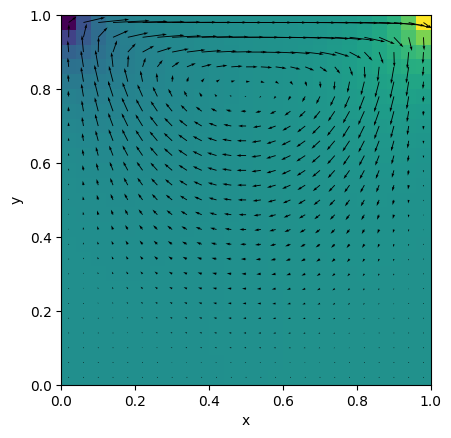

In [2]:
fg = VectorField(u)
rhs = ScalarField(p)

for n in range(1000):

    dt, (n_it, norm) = comp_ts(u, p)

fig, ax = plt.subplots()
p_plot.pcolormesh(p, ax=ax)
vec_plot.quiver(u, ax=ax)
ax.set_aspect('equal', 'box')
ax.set_xlabel("x")
ax.set_ylabel("y")

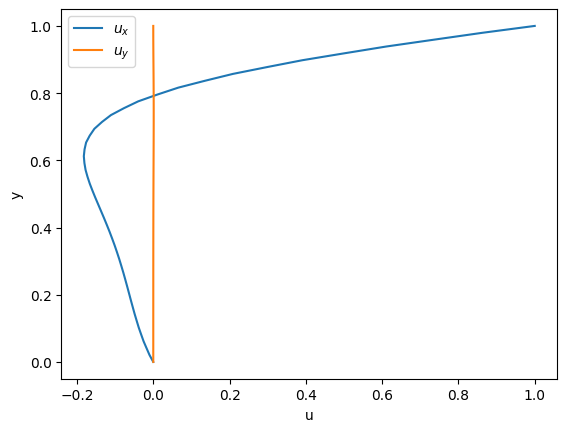

In [3]:
import numpy as np

from nsfdpy.interp import VectorFieldInterp


u_interp = VectorFieldInterp(grid, u)
res = []
frac = 0.5
x = frac * nsfd_config.geometry().xlength
y = np.linspace(0, nsfd_config.geometry().ylength)
for y_i in y:
    res.append(u_interp(x, y_i))

res = np.array(res)

plt.plot(res[:, 0], y, label="$u_x$")
plt.plot(res[:, 1], y, label="$u_y$")
plt.xlabel("u")
plt.ylabel("y")
plt.legend()

(0.0, 1.0)

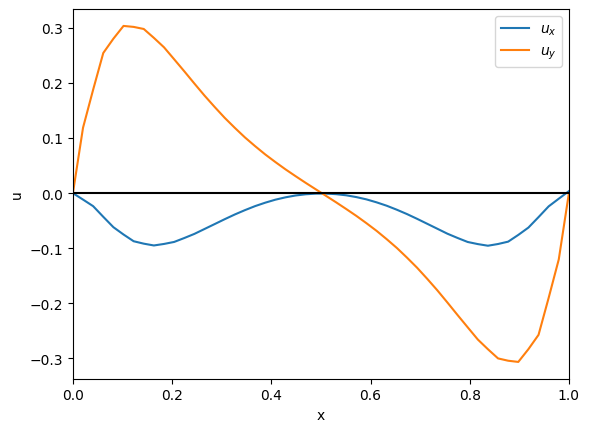

In [4]:
import numpy as np

from nsfdpy.interp import VectorFieldInterp


frac = np.interp(0, res[1:,0], y[1:])
u_interp = VectorFieldInterp(grid, u)
res = []
x = np.linspace(0, nsfd_config.geometry().xlength)
y = frac * nsfd_config.geometry().ylength
for x_i in x:
    res.append(u_interp(x_i, y))

res = np.array(res)

plt.plot(x, res[:, 0], label="$u_x$")
plt.plot(x, res[:, 1], label="$u_y$")
plt.hlines(0, 0, 1, "k")
plt.xlabel("x")
plt.ylabel("u")
plt.legend()
plt.xlim(0,1)